# Discretized Logistic Mixture distribution 

**Goal:** In this notebook you will work with TFP. First you plot the probability density function and the cumulative probability density function for the logistic distribution for diffrent location and scale parameters. Then you will discretize the logistic distribution which is continuous and can output any value, to be a discrete distribution and only output certain integer values. You will see how you can mix two discrete logistic distributions and again to get a resulting distribution which is discrete. Finally you learn how to build a model with TensorFlow and TFP to use the discretized logistic mixture distribution as output.


**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.  

**Content:**
* Work with the logistic distribution in TFP
* Discretize the logistic distribution
* Mix two logistic distribution to one distribution 
* Discretize the mixture of two logistic distributions 
* Define a model with Keras and TFP to use the discretized logistic mixture distribution as output


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_01.ipynb)


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib.axes import Axes
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from typing import *

tfd = tfp.distributions
tfb = tfp.bijectors


### A single logistic distribution 
Let's start with the single logistic function and plot the probability density function and the cumulative probability density function. You maybe know this function more by it's cumulative probability distrubution which is used in case of logistic regression. You use the same location parameter for all three distributions and change the scale parameter, you can see that the density gets broader around the location which is 1, when you increase the scale parameter.

In [2]:
def plot_distribution(axes: List[Axes], dist: tfd.Distribution, x: np.ndarray, color: str, ls: str, label: str) -> List[Axes]:
    axes[0].plot(x, dist.prob(x), color=color, ls=ls, label=label)
    axes[1].plot(x, dist.cdf(x), color=color, ls=ls, label=label)
    return axes

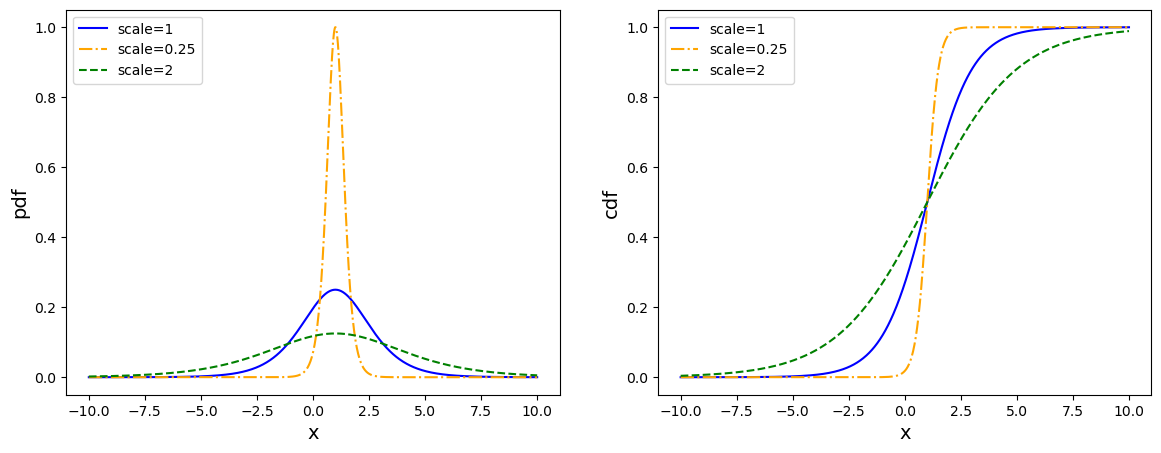

In [3]:
x = np.linspace(-10, 10, 1000)
loc = 1
scales = [1, 0.25, 2]
line_styles = [None, "-.", "--"]
colors = ["blue", "orange", "green"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
for i, scale in enumerate(scales):
    ls = line_styles[i]
    color=colors[i]
    dist = tfd.Logistic(loc=loc, scale=scale)
    plot_distribution(axes, dist, x, color, ls, f"scale={scale}")

axes[0].set_xlabel("x", fontsize=14)
axes[0].set_ylabel("pdf", fontsize=14)
axes[0].legend(loc='upper left')

axes[1].set_xlabel("x", fontsize=14)
axes[1].set_ylabel("cdf", fontsize=14)
axes[1].legend(loc='upper left')    
    
plt.show()

### Discretization of the logistic distribution

The QuantizedDistribution takes a probability distributions and creates a quantized version of it. From the documentation https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution we know:

1. Draw X (from distribution)
2. Set Y <-- ceiling(X)
3. If Y < low, reset Y <-- low
4. If Y > high, reset Y <-- high
5. Return Y

To create integer values which are capted between 0 and $2^{bits} - 1$, we can use the following code. The ceiling of x is just the next interger that is larger (or equal than x). For example: 

In [4]:
def plot_quantized_distribution(axes: List[Axes], dist: tfd.Distribution, n_vals: np.ndarray, x: np.ndarray, color: str, label: str) -> List[Axes]:
    axes[0].stem(n_vals, dist.prob(n_vals), markerfmt='C1o', linefmt='C1-.', label=label)
    axes[1].plot(x, dist.cdf(x), color=color, label=label)
    return axes

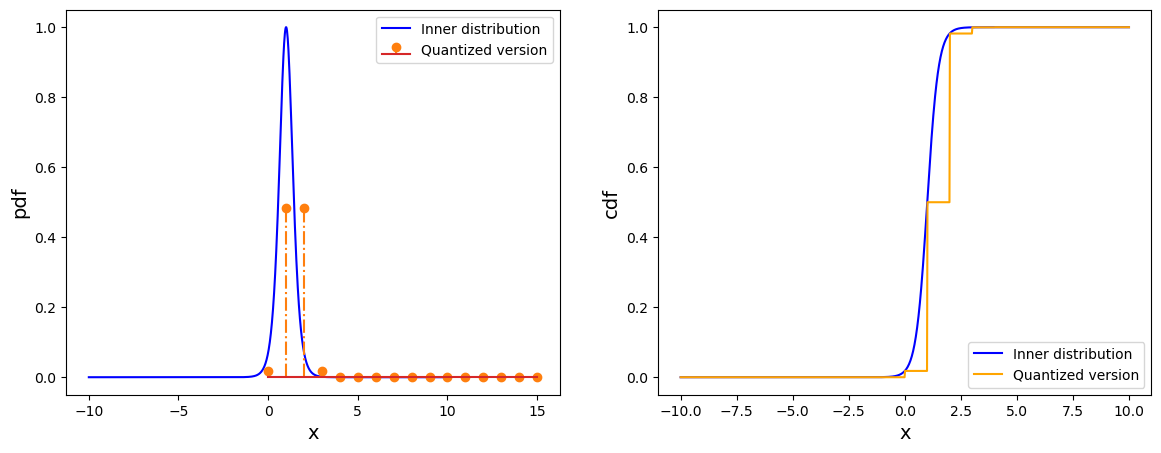

In [5]:
bits = 4
n_vals = np.arange(16)
x = np.linspace(-10, 10, 1000)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

logistic_dist = tfd.Logistic(loc=1, scale=0.25)
discretized_logistic_dist = tfd.QuantizedDistribution(logistic_dist, low=0, high=2 ** bits - 1)

plot_distribution(axes, logistic_dist, x, color="blue", ls=None, label="Inner distribution")
plot_quantized_distribution(axes, discretized_logistic_dist, n_vals=n_vals, x=x, color="orange", label="Quantized version")

axes[0].legend(loc="upper right")
axes[0].set_xlabel('x', fontsize=14)
axes[0].set_ylabel('pdf', fontsize=14)

axes[1].legend(loc="lower right")
axes[1].set_xlabel('x', fontsize=14)
axes[1].set_ylabel('cdf', fontsize=14)
plt.show()

In [6]:
np.sum(discretized_logistic_dist.prob(n_vals))

1.0

In [7]:
discretized_logistic_dist.sample(10).numpy()

array([1., 2., 1., 2., 2., 1., 2., 1., 2., 1.], dtype=float32)

As you can see the peak of probability density function of the quatized version is not at the same position as the inner distribution. This is due to taking the ceil. Luckily, there is an easy workaround. You can just shift the distribution 0.5 to the left and then we have proper rounding.  
In next the cell you just shift the logistic distribution 0.5 to the left. You can do this with the tfd.TransformedDistribution function, you have to define which distribution you want to use and with the bijector=tfb.AffineScalar(shift=-0.5) argument you can shift the distribution by 0.5. We again plot the probability density function and the cumulative probability density function for all three versions.

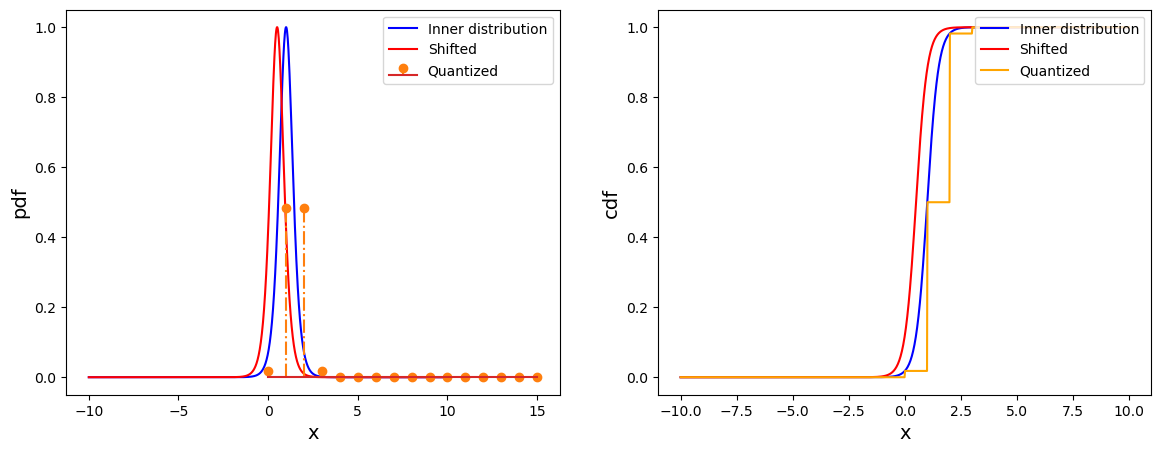

In [8]:
bits = 4

logi = tfd.Logistic(loc=1, scale=0.25)
shift_logi = tfd.TransformedDistribution(distribution=logi, bijector=tfb.Shift(-0.5))  # shift x to left
quantized_logi = tfd.QuantizedDistribution(distribution=logi, low=0, high=2**bits - 1)

x = np.linspace(-10, 10, 1000)
n_vals = np.arange(16)

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
plot_distribution(axes, dist=logi, x=x, color="blue", ls=None, label="Inner distribution")
plot_distribution(axes, dist=shift_logi, x=x, color="red", ls=None, label="Shifted")
plot_quantized_distribution(axes, dist=quantized_logi, x=x, n_vals=n_vals, color="orange", label="Quantized")

axes[0].legend(loc="upper right")
axes[0].set_xlabel("x", fontsize=14)
axes[0].set_ylabel("pdf", fontsize=14)

axes[1].legend(loc="upper right")
axes[1].set_xlabel("x", fontsize=14)
axes[1].set_ylabel("cdf", fontsize=14)
plt.show()

In [9]:
# make quantized version is at the same position as the inner distribution

def shift_quantize(inner: tfd.Distribution, bits: int) -> tfd.Distribution:
    trans = tfd.TransformedDistribution(distribution=inner, bijector=tfb.Shift(-0.5))
    return tfd.QuantizedDistribution(distribution=trans, low=0, high=2**bits - 1)

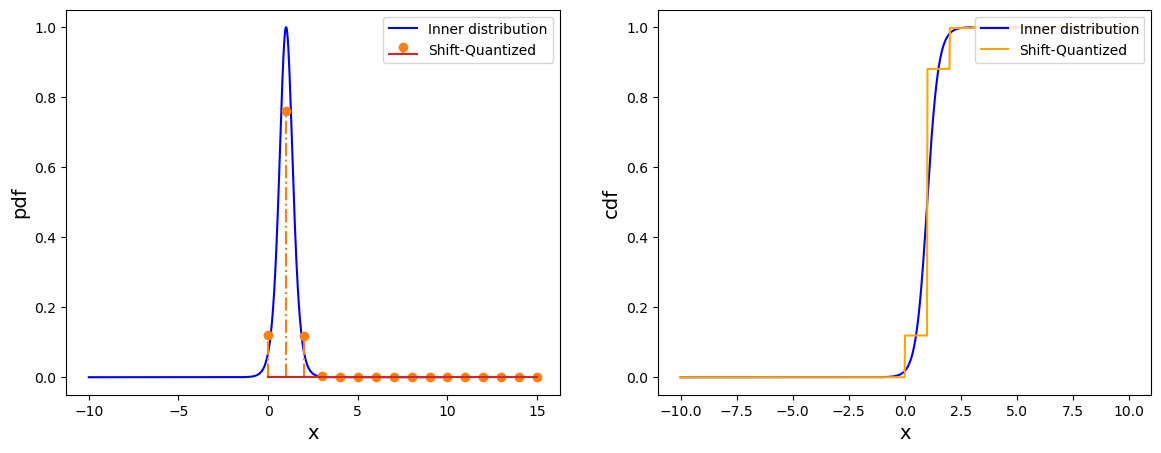

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
plot_distribution(axes, dist=logi, x=x, color="blue", ls=None, label="Inner distribution")
plot_quantized_distribution(axes, dist=shift_quantize(logi, bits=bits), x=x, n_vals=n_vals, color="orange", label="Shift-Quantized")

axes[0].legend(loc="upper right")
axes[0].set_xlabel("x", fontsize=14)
axes[0].set_ylabel("pdf", fontsize=14)

axes[1].legend(loc="upper right")
axes[1].set_xlabel("x", fontsize=14)
axes[1].set_ylabel("cdf", fontsize=14)
plt.show()

Now you can see the peak of probability density function of the quatized version is at same position as the inner distribution. And we have a nice discrete verson of the inner distribution.

### Mixture of logistic distributions and quantized version of the mixtures

Having the quantized distributions, we can now mix them to get more flexible distributions. For this, we use the "MixtureOfSameFamily" distribution. We will mix two logistic distributions with the locs = (4,10) and the scales = (0.25,05) and quantize them as before. Finally we have to use the "MixtureOfSameFamily" function to mix the two distributions and only get one output, we do the mixture by using a categorical distribution with 80% for the first logistic distribution and 20% for the second logistic distribution. We again plot the probability density function and the cumulative probability density function for the mixture 

In [11]:
locs = (4.0, 10.0) 
scales = (0.25, 0.5)
probs = (0.8, 0.2)

dists = tfd.Logistic(loc=locs, scale=scales)
quant = shift_quantize(dists, bits=4)

mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=probs), components_distribution=dists)
quant_mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=probs), components_distribution=quant)

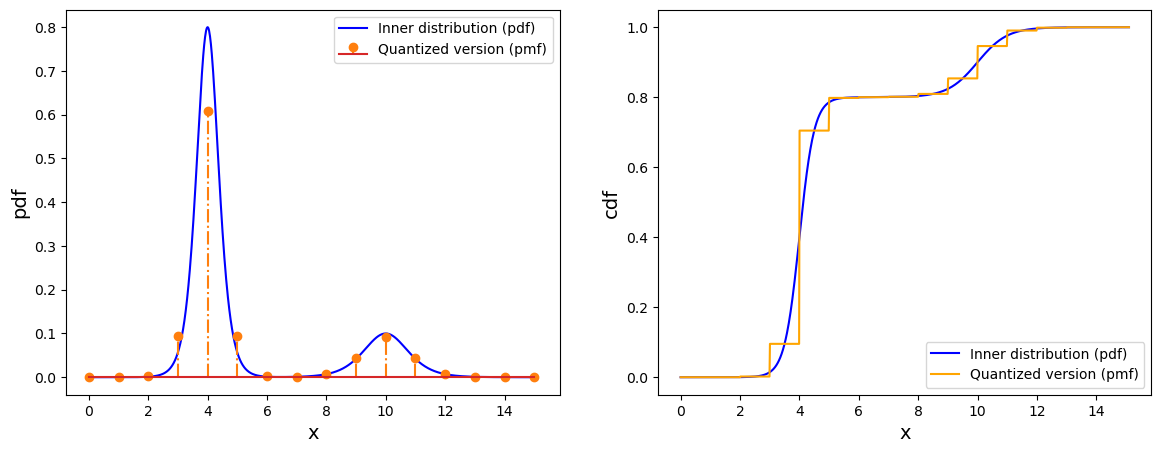

In [12]:
x = np.linspace(0,15.1,1000)
n_vals = np.arange(16)

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
plot_distribution(axes, dist=mixture, x=x, color="blue", ls=None, label="Inner distribution (pdf)")
plot_quantized_distribution(axes, dist=quant_mixture, x=x, n_vals=n_vals, color="orange", label="Quantized version (pmf)")

axes[0].legend(loc="upper right")
axes[0].set_xlabel("x", fontsize=14)
axes[0].set_ylabel("pdf", fontsize=14)
axes[1].legend(loc="lower right")
axes[1].set_xlabel("x", fontsize=14)
axes[1].set_ylabel("cdf", fontsize=14)
plt.show()

### Using the mixture of logistics in a neural netwok

In the next cell you see example code how to use the mixutre of logistics for a neural network.
Fist you define the quant_mixture_logistic function and then you can use it with the tfp.layers.DistributionLambda layer as the output for your model.  
See aslo: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution.  
For each mixture component the NN needs to estimate three parameters: The location of the component, the spread and how much the component is weighted. Note that the output should be without activation (as it is default in Keras).

In [20]:
def quant_mixture_logistic(out: tf.Tensor, bits: int = 8, n_args: int = 3):  
    loc, un_scale, logits = tf.split(out, num_or_size_splits=n_args, axis=-1)
    scale = tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
        distribution=tfd.TransformedDistribution(distribution=tfd.Logistic(loc=loc, scale=scale), bijector=tfb.Shift(-0.5)),
        low=0., high=2**bits - 1.)
    
    # 传入的是logits，不是 probs
    return tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logits), components_distribution=discretized_logistic_dist)


inputs = Input(shape=(100,))  
h1 = Dense(10, activation='tanh')(inputs)
out = Dense(6)(h1)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)

model = Model(inputs=inputs, outputs=p_y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 dense_3 (Dense)             (None, 6)                 66        
                                                                 
 distribution_lambda_1 (Dist  ((None,),                0         
 ributionLambda)              (None,))                           
                                                                 
Total params: 1,076
Trainable params: 1,076
Non-trainable params: 0
_________________________________________________________________
